# Multi-label классификация по ключевым словам


## Импорты

In [1]:
import os
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

2022-03-23 13:37:36.852006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 13:37:36.852028: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
ROOT_DIR = os.path.split(os.getcwd())[0]
DATA_DIR = os.path.join(ROOT_DIR, 'data', 'processed')
DATA_DIR


'/home/margarita/github/hse-nlp-2022/data/processed'

from google.colab import drive
drive.mount('/content/drive')

## Предварительная работа с данными
Загрузим предобработанный датасет в датафрейм `pandas`. Из абстрактов были предварительно удалены знаки препинания, сам текст переведен в lower case.

In [3]:
fname = os.path.join(DATA_DIR, 'top5.csv')
data = pd.read_csv(fname, sep=',', quotechar='"', encoding='utf-8', engine='python')
data.head()

,journal,DOI,abstract,keywords
0,ieee-proc,10.1109/JPROC.2013.2257631,the wireless sensor network wsn technology spa...,['Control systems']
1,ieee-proc,10.1109/JPROC.2010.2064151,owing in part to complementary metaloxidesemic...,['Logic gates']
2,ieee-proc,10.1109/JPROC.2010.2065211,semiconductor nanowires have attracted conside...,['Silicon']
3,ieee-proc,10.1109/JPROC.2010.2063411,power density has grown to be the dominant cha...,['Logic gates']
4,ieee-proc,10.1109/JPROC.2010.2070470,steep subthreshold swing transistors based on ...,['Logic gates']


В качестве текстовых фичей мы используем абстракты `abstract`, в качестве лейблов - клчевые слова `keywords`, указанные в соответствующих статьях.


In [4]:
print(f"Количество статей: {len(data)}")

Количество статей: 17162


Приведем лейблы к более удобному формату:

In [5]:
data["keywords"] = data["keywords"].apply(
    lambda x: literal_eval(x)
)
data["keywords"].values[:5]

array([list(['Control systems']), list(['Logic gates']),
       list(['Silicon']), list(['Logic gates']), list(['Logic gates'])],
      dtype=object)

Разобьем данные на тестовую, валидационную и тренировочную выборки.

In [6]:
test_split = 0.1

train_df, test_df = train_test_split(
    data,
    test_size=test_split,
)

val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Статей в тренировочной выборке: {len(train_df)}")
print(f"Статей в валидационной выборке: {len(val_df)}")
print(f"Статей в тестовой выборке: {len(test_df)}")

Статей в тренировочной выборке: 15445
Статей в валидационной выборке: 858
Статей в тестовой выборке: 859


/home/margarita/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Создание словаря и one-hot encoding

Используя слой `StringLookUp`, получим словарь из ключевых слов и закодируем их.

In [7]:
terms = tf.ragged.constant(train_df["keywords"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Словарь:\n")
print(vocab)
print()
example = tf.ragged.constant(vocab)[0]
print("Пример закодированного вектора:\n")
print(lookup(example).numpy())

2022-03-23 13:37:50.530939: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-23 13:37:50.530998: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (margarita-Swift): /proc/driver/nvidia/version does not exist
2022-03-23 13:37:50.532019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Словарь:

['[UNK]', 'Control systems', 'Logic gates', 'Equations', 'Silicon', 'Linear systems']

Пример закодированного вектора:

[1. 0. 0. 0. 0. 0.]


## Сбор итогового датасета

Для дальнейшего обучения будет полезно посмотреть на характеристики абстрактов.

In [8]:
train_df["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    15445.000000
mean       111.395727
std         55.523417
min          2.000000
25%         68.000000
50%        105.000000
75%        147.000000
max        390.000000
Name: abstract, dtype: float64

Видим, что у половины статей длина абстракта не превышает 105 слов. Таким образом, в дальнейшем разумно брать примерно такую максимальную длину текста для обучения модели.

Соберем датасет, состоящий из абстрактов и one-hot векторов, представляющих ключевые слова.

In [9]:
max_seqlen = 105
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["keywords"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["abstract"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In [10]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

Выведем некоторые примеры из этого датасета:

In [11]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'an analytical technique is described for the estimation of the parameters of linear thirdorder systems the expressions giving the parameter values in terms of the magnitude of the system step response at specified instants of time are derived the technique is illustrated by considering two different thirdorder systems'
Label(s): ['Control systems' 'Equations']
 
Abstract: b'recent progress in stackelberg dynamic games concentrates on either the deterministic situations or partially nested stochastic problems in this paper a class of nonnested stochastic stackelberg dynamic games namely log additive incentive problems is solved by explicitly introducing two essential ideasmatching answers and gpd phenomenon each incentive problem can be converted into a set of decoupled inverse team problems itps the solution of each itp can then be found by solving a set of linear algebraic equations if it exists moreover it is shown that for a wide class of problems if there exist more age

## Векторизация текста
Посмотрим, насколько большим будет словарь, полученный из абстрактов.


In [12]:
vocabulary = set()
train_df["abstract"].str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print("Размер словаря:", vocabulary_size)

Размер словаря: 36571



Для того, чтобы модель могла работать с нашими текстами, нужно конвертировать информацию в числа. Для этого воспользуемся готовым слоем `TextVectorization`. Сначала этот слой разобьет тест на биграммы, потом выдаст представления, используя `TF-IDF`.

In [13]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


## Обучаемая модель
В качестве модели используем достаточно простую сеть, состоящую из пары полносвязных слоев с ReLU в качестве функции активации.


In [14]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  
    )
    return shallow_mlp_model


Epoch 1/20
121/121 [==============================] - 9s 68ms/step - loss: 0.2798 - categorical_accuracy: 0.6825 - val_loss: 0.2359 - val_categorical_accuracy: 0.7121
Epoch 2/20
121/121 [==============================] - 9s 71ms/step - loss: 0.0743 - categorical_accuracy: 0.8873 - val_loss: 0.3253 - val_categorical_accuracy: 0.6725
Epoch 3/20
121/121 [==============================] - 10s 83ms/step - loss: 0.0164 - categorical_accuracy: 0.9050 - val_loss: 0.5073 - val_categorical_accuracy: 0.6620
Epoch 4/20
121/121 [==============================] - 10s 85ms/step - loss: 0.0072 - categorical_accuracy: 0.9126 - val_loss: 0.5873 - val_categorical_accuracy: 0.6538
Epoch 5/20
121/121 [==============================] - 10s 83ms/step - loss: 0.0033 - categorical_accuracy: 0.9062 - val_loss: 0.6376 - val_categorical_accuracy: 0.6690
Epoch 6/20
121/121 [==============================] - 11s 88ms/step - loss: 0.0015 - categorical_accuracy: 0.9105 - val_loss: 0.7303 - val_categorical_accuracy: 0

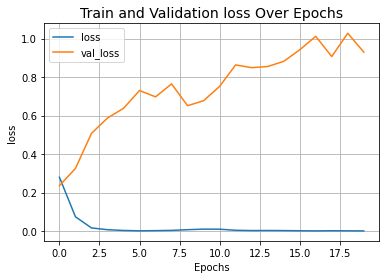

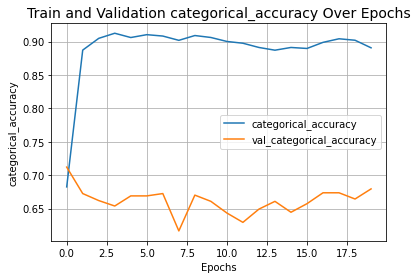

In [15]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

Проверим точность на тестовой выборке:

In [16]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

7/7 [==============================] - 0s 22ms/step - loss: 0.9587 - categorical_accuracy: 0.6764
Categorical accuracy on the test set: 67.64%.
